# Data Visualization Part

### What we'll do here
- Load the 2018 CitiBike data with Dask
- Engineer time features and clean the dataset
- Profile trip duration and temporal demand patterns
- Compare demand across representative station zones
- Build interactive station pickup maps with Plotly

### How to run
1. Make sure you have the data in the expected data folder.
2. Run each step top-to-bottom to regenerate the plots and HTML outputs.

### Table of Contents
- [1.1 Imports](#11-imports)
- [1.2 Load data](#12-load-data)
- [1.3 Add datetime features](#13-add-datetime-features)
- [1.4 Clean and filter rides](#14-clean-and-filter-rides)
- [1.5 Trip duration distribution](#15-trip-duration-distribution)
- [1.6 Trips by hour and weekday](#16-trips-by-hour-and-weekday)
- [1.7 Define station zones](#17-define-station-zones)
- [1.8 Busiest stations by zone](#18-busiest-stations-by-zone)
- [1.9 Hourly patterns for sample stations](#19-hourly-patterns-for-sample-stations)
- [1.10 Hourly share by land-use type](#110-hourly-share-by-land-use-type)
- [1.11 Build full-station pickup map](#111-build-full-station-pickup-map)
- [1.12 Busiest-station spotlight map](#112-busiest-station-spotlight-map)
- [1.13 Add NYC landmarks overlay](#113-add-nyc-landmarks-overlay)
- [1.14 Export interactive maps](#114-export-interactive-maps)

### 1.1 Imports

Load plotting, clustering, and data utilities used throughout this notebook.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')   

### 1.2 Load data

Read the 2018 CitiBike trips with Dask to keep the IO memory friendly.

In [2]:
import dask.dataframe as dd

nyc_bike = dd.read_csv("../data/trips_2018.csv")

### 1.3 Add datetime features

Parse timestamps and derive hour, weekday, and month fields for downstream visuals.

In [3]:
# Converting date & time
nyc_bike['starttime'] = dd.to_datetime(nyc_bike['starttime'], errors = 'coerce')
nyc_bike['stoptime'] = dd.to_datetime(nyc_bike['stoptime'], errors = 'coerce')
nyc_bike['starttime'].head()

# Extracting hour/day/month
nyc_bike['start_hour'] = nyc_bike['starttime'].dt.hour
nyc_bike['start_day'] = nyc_bike['starttime'].dt.dayofweek
nyc_bike['start_month'] = nyc_bike['starttime'].dt.month

### 1.4 Clean and filter rides

Drop duplicates, invalid durations, out-of-bound coordinates, and keep valid user types.

In [4]:
# 1) Remove duplicates (lazy, safe)
nyc_bike = nyc_bike.drop_duplicates()

# 2) Drop missing timestamps
nyc_bike = nyc_bike.dropna(subset=['starttime', 'stoptime'])

# 3) Compute trip duration (in seconds)
nyc_bike['duration'] = (nyc_bike['stoptime'] - nyc_bike['starttime']).dt.total_seconds()
# Remove trips with invalid duration (zero, negative, or missing)
nyc_bike = nyc_bike[nyc_bike['duration'] > 0]

# 5) Remove invalid or out-of-bound coordinates
nyc_bike = nyc_bike[
    (nyc_bike['start_station_latitude'].between(40, 41)) &
    (nyc_bike['start_station_longitude'].between(-74.3, -73.6)) &
    (nyc_bike['end_station_latitude'].between(40, 41)) &
    (nyc_bike['end_station_longitude'].between(-74.3, -73.6))
]

# 6) Optional: keep only valid user types
nyc_bike = nyc_bike[nyc_bike['usertype'].isin(['Customer', 'Subscriber'])]

# 7) Optional: remove super-long trips (>24 hours)
nyc_bike = nyc_bike[nyc_bike['duration'] < 24*3600]

# 8) Preview (safe compute)
# nyc_bike.head()

### 1.5 Trip duration distribution

Plot a histogram on a large sample to see how long most trips last.

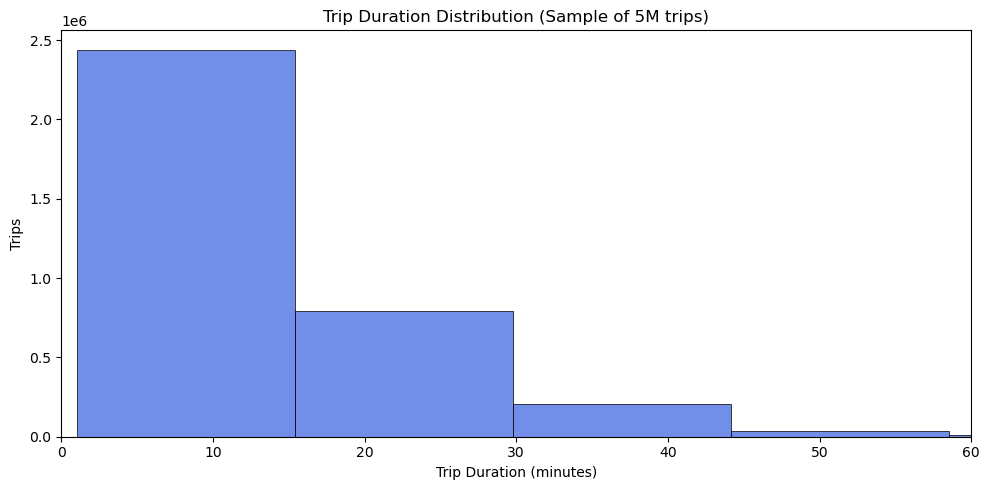

In [5]:
# Computing a histogram of trip duration based only on 5 million
durations = nyc_bike['duration'].sample(frac=0.2).compute() / 60

plt.figure(figsize=(10, 5))
sns.histplot(durations, bins=100, color='royalblue')
plt.xlim(0, 60)
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Trips")
plt.title("Trip Duration Distribution (Sample of 5M trips)")
plt.tight_layout()
plt.show()

### 1.6 Trips by hour and weekday

Heatmap pickups across hours and weekdays to spot the weekly cadence.

In [6]:
# Heatmap of trips by Hour x Weekday
heatmap_data = (
    nyc_bike.groupby(['start_day', 'start_hour'])
            .size()
            .compute()
)
heatmap_df = heatmap_data.unstack(level=1)

day_map = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday"
}

heatmap_df.index = heatmap_df.index.map(day_map)
plt.figure(figsize=(14,6))
sns.heatmap(heatmap_df, cmap='viridis')
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.title("Trips by Hour and Weekday")
plt.show()

KeyboardInterrupt: 

### 1.7 Define station zones

Group stations into business, residential, and recreational slices using coordinate filters.

In [ ]:
# Picking up some stations

# Get unique stations with their coordinates
stations = nyc_bike[['start_station_id', 'start_station_latitude', 'start_station_longitude']] \
            .dropna() \
            .drop_duplicates() \
            .compute()

# BUSINESS DISTRICT (Manhattan: Midtown + FiDi)
business_zone = stations[
    (stations['start_station_latitude'].between(40.70, 40.77)) &
    (stations['start_station_longitude'].between(-74.00, -73.97))
]

# RESIDENTIAL (Brooklyn: Cobble Hill, Clinton Hill, Williamsburg)
residential_zone = stations[
    (stations['start_station_latitude'].between(40.69, 40.78)) &
    (stations['start_station_longitude'].between(-74.02, -73.93))
]

# RECREATIONAL (Waterfront + parks: Central Park + Brooklyn Bridge Park)
recreational_zone = stations[
    (stations['start_station_latitude'].between(40.68, 40.73)) &
    (stations['start_station_longitude'].between(-74.02, -74.00))
]

### 1.8 Busiest stations by zone

Find the top stations in each zone to anchor the comparisons.

In [ ]:
def top_busiest(n, zone):
    station_ids = zone['start_station_id'].unique()

    counts = (
        nyc_bike[nyc_bike['start_station_id'].isin(station_ids)]
        .groupby('start_station_id')
        .size()
        .compute()
        .sort_values(ascending=False)
        .head(n)
    )

    return counts

In [ ]:
top3_business = top_busiest(3, business_zone)
top3_residential = top_busiest(3, residential_zone)
top3_recreational = top_busiest(3, recreational_zone)

top3_business, top3_residential, top3_recreational

(start_station_id
 519.0    150246
 497.0    108865
 435.0    107154
 dtype: int64,
 start_station_id
 519.0    150246
 497.0    108865
 435.0    107154
 dtype: int64,
 start_station_id
 426.0     94453
 3002.0    76852
 387.0     70755
 dtype: int64)

### 1.9 Hourly patterns for sample stations

Plot representative hourly curves for a business, residential, and recreational station.

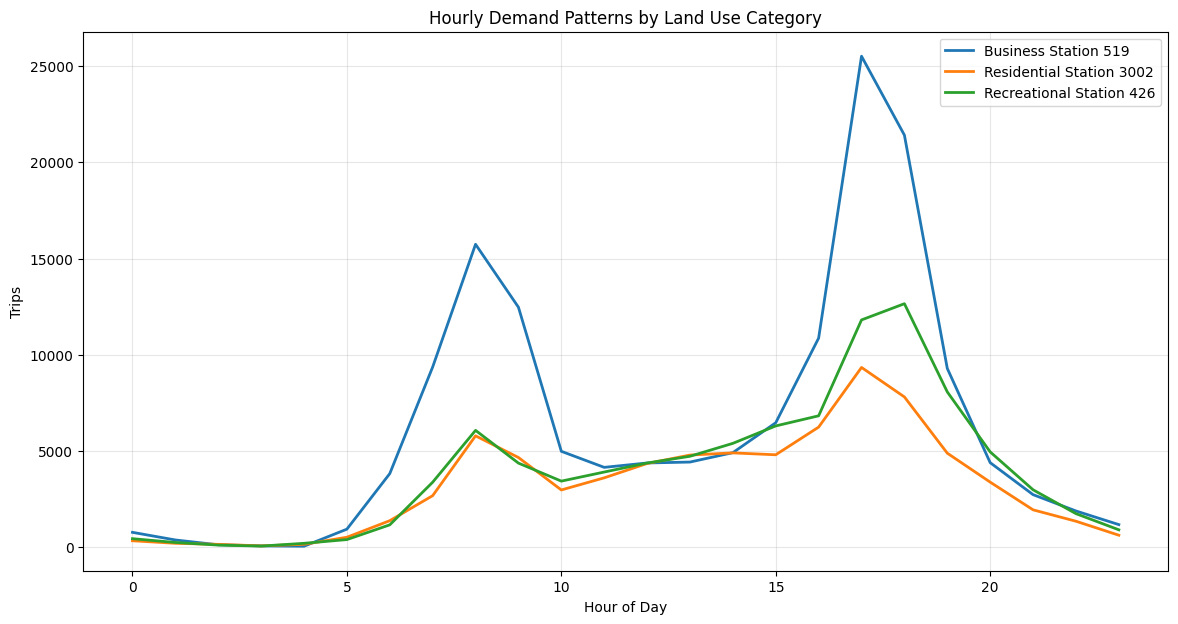

In [ ]:
def hourly_curve(station_id):
    data = nyc_bike[nyc_bike['start_station_id'] == station_id]
    hourly = data.groupby('start_hour').size().compute().sort_index()
    return hourly

business_curve = hourly_curve(519)
residential_curve = hourly_curve(3002)
recreational_curve = hourly_curve(426)

plt.figure(figsize=(14,7))
plt.plot(business_curve.index, business_curve.values, label='Business Station 519', linewidth=2)
plt.plot(residential_curve.index, residential_curve.values, label='Residential Station 3002', linewidth=2)
plt.plot(recreational_curve.index, recreational_curve.values, label='Recreational Station 426', linewidth=2)

plt.title('Hourly Demand Patterns by Land Use Category')
plt.xlabel('Hour of Day')
plt.ylabel('Trips')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### 1.10 Hourly share by land-use type

Compare the share of trips across land-use types throughout the day.

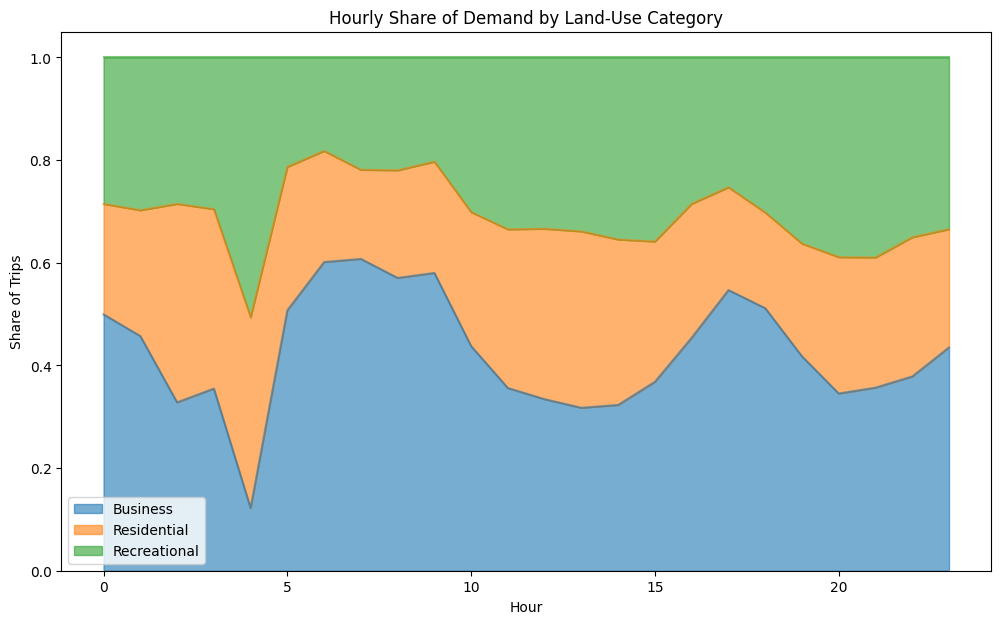

In [ ]:
def hourly_counts_for(station_id):
    return (
        nyc_bike[nyc_bike['start_station_id'] == station_id]
        .groupby('start_hour')
        .size()
    )

business = hourly_counts_for(519).compute()
residential = hourly_counts_for(3002).compute()
recreational = hourly_counts_for(426).compute()

df = pd.DataFrame({
    'Business': business,
    'Residential': residential,
    'Recreational': recreational
}).fillna(0)

df_pct = df.div(df.sum(axis=1), axis=0)

df_pct.plot.area(figsize=(12,7), alpha=0.6)
plt.title("Hourly Share of Demand by Land-Use Category")
plt.xlabel("Hour")
plt.ylabel("Share of Trips")
plt.show()

### 1.11 Build full-station pickup map

Assemble station coordinates and pickup totals, then render all locations on a Mapbox map.

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# 1) Loading all stations
usecols = ['start_station_id', 'start_station_latitude', 'start_station_longitude']

stations_list = []

# read in chunks
for chunk in pd.read_csv("Trips_2018.csv", usecols=usecols, chunksize=500000):
    stations_list.append(
        chunk.dropna().drop_duplicates(subset='start_station_id')
    )

stations = pd.concat(stations_list).drop_duplicates(subset='start_station_id')

# rename for convenience
stations.rename(columns={
    'start_station_latitude': 'Latitude',
    'start_station_longitude': 'Longitude'
}, inplace=True)


# 2) Coun pickups over all stations
pickup_counts = {}
chunksize = 500000

for chunk in pd.read_csv("Trips_2018.csv", usecols=['start_station_id'], chunksize=chunksize):
    for s in chunk['start_station_id']:
        pickup_counts[s] = pickup_counts.get(s, 0) + 1

pickup_df = (
    pd.DataFrame.from_dict(pickup_counts, orient="index", columns=["pickups"])
    .reset_index()
    .rename(columns={'index': 'start_station_id'})
)


# 3) Merge stations and pickups
stations = stations.merge(pickup_df, on="start_station_id", how="left")
stations['pickups'].fillna(0, inplace=True)


# 4) Top 5 busiest stations
top5 = stations.nlargest(5, 'pickups')



# 5) BUBBLE SIZE SCALING (smooth & beautiful)
sizes = np.interp(
    stations['pickups'],
    (stations['pickups'].min(), stations['pickups'].max()),
    (8, 40)
)


# 6) Building the map
fig1 = go.Figure()

# MAIN MAP LAYER
fig1.add_trace(go.Scattermapbox(
    lat=stations['Latitude'],
    lon=stations['Longitude'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=sizes,
        color=stations['pickups'],
        colorscale='Viridis',
        cmin=stations['pickups'].min(),
        cmax=stations['pickups'].max(),
        showscale=True,
        colorbar=dict(
            title='Pickup Count',
            thickness=20,
            outlinewidth=0,
            tickfont=dict(size=12),
        ),
    ),
    hovertemplate=
        "<b>Station ID:</b> %{customdata[0]}<br>" +
        "<b>Pickups:</b> %{customdata[1]:,}<br>" +
        "<extra></extra>",
    customdata=np.stack([stations['start_station_id'], stations['pickups']], axis=-1)
))


# Labeling (idk if it will work)
fig1.add_trace(go.Scattermapbox(
    lat=top5['Latitude'],
    lon=top5['Longitude'],
    mode='text',
    text=top5['start_station_id'].astype(str),
    textposition="top right",
    textfont=dict(size=13, color="black", family="Arial"),
    hoverinfo='none'
))


# Map
fig1.update_layout(
    mapbox_style="carto-positron",
    mapbox=dict(
        zoom=11.8,
        center=dict(
            lat=stations['Latitude'].mean(),
            lon=stations['Longitude'].mean()
        )
    ),
    height=900,
    width=950,
    margin={"r":0,"t":70,"l":0,"b":0},
    title=dict(
        text="<b>NYC CitiBike Pickup Map (2018)</b><br>"
             "<span style='font-size:15px;color:#555;'>All stations shown • Bubble size & color reflect total pickup volume</span>",
        x=0.5,
        y=0.97,
        xanchor='center',
        yanchor='top',
        font=dict(size=24),
    )
)

fig1.show()


### 1.12 Busiest-station spotlight map

Filter to the highest-volume stations and plot a focused view.

In [ ]:
# Only stations from 75K and more pick ups
busiest = stations[stations['pickups'] >= 75000].copy()

# bubble sizes (bigger because fewer points)
sizes = np.interp(
    busiest['pickups'],
    (busiest['pickups'].min(), busiest['pickups'].max()),
    (20, 60)
)

fig2 = go.Figure()

# Mai Layer
fig2.add_trace(go.Scattermapbox(
    lat=busiest['Latitude'],
    lon=busiest['Longitude'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=sizes,
        color=busiest['pickups'],
        colorscale='Plasma',
        showscale=True,
        cmin=busiest['pickups'].min(),
        cmax=busiest['pickups'].max()
    ),
    hovertemplate="<b>Station ID:</b> %{customdata[0]}<br>"
                  "<b>Pickups:</b> %{customdata[1]:,}<extra></extra>",
    customdata=np.stack([busiest['start_station_id'], busiest['pickups']], axis=-1)
))


fig2.add_trace(go.Scattermapbox(
    lat=busiest['Latitude'],
    lon=busiest['Longitude'],
    mode='text',
    text=busiest['start_station_id'].astype(str),
    textposition="top center",
    textfont=dict(size=14, color="black"),
    hoverinfo='none'
))


fig2.update_layout(
    mapbox_style="carto-positron",
    mapbox=dict(
        zoom=12.0,
        center=dict(
            lat=busiest['Latitude'].mean(),
            lon=busiest['Longitude'].mean()
        )
    ),
    title=dict(
        text="<b>NYC CitiBike: Busiest Stations Only (≥ 75,000 Pickups)</b><br>"
             "<span style='font-size:15px;color:#444;'>Only the top-demand stations are shown</span>",
        x=0.5,
        y=0.97,
    ),
    height=900,
    width=950,
    margin={"r":0,"l":0,"t":70,"b":0}
)

fig2.show()


### 1.13 Add NYC landmarks overlay

Layer key landmarks on the map to orient the highest-demand stations.

In [ ]:
nyc_landmarks = pd.DataFrame({
    "name": [
        "Wall Street",
        "Times Square",
        "Central Park",
        "Brooklyn Bridge",
        "Union Square",
        "Grand Central Terminal",
        "Battery Park",
        "High Line",
        "Manhattan (Business District)"
    ],
    "lat": [
        40.7075,
        40.7580,
        40.7829,
        40.7061,
        40.7359,
        40.7527,
        40.7033,
        40.7478,
        40.7685
    ],
    "lon": [
        -74.0113,
        -73.9855,
        -73.9654,
        -73.9969,
        -73.9911,
        -73.9772,
        -74.0170,
        -74.0040,
        -73.9822
    ]
})

In [ ]:
# Adding them to my map
fig2.add_trace(
    go.Scattermapbox(
        lat=nyc_landmarks["lat"],
        lon=nyc_landmarks["lon"],
        mode="markers+text",
        marker=go.scattermapbox.Marker(
            size=12,
            color="red"
        ),
        text=nyc_landmarks["name"],
        textposition="top right",
        name="NYC Landmarks"
    )
)